In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from hdecoder.BaseModel import BaseModel
from hdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
from utils.arguments import load_vcoco_opt_command, load_vcoco_parser

cmdline_args = load_vcoco_parser()
cmdline_args.conf_files = [os.path.join(home_dir, "configs/hdecoder/vcoco.yaml")]
# cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides = ['DONT_LOAD_MODEL', 'false', 'PYLEARN_MODEL', '../data/output/test/00062100/default/raw_model_states.pt'] 

opt = load_vcoco_opt_command(cmdline_args)
opt = init_distributed(opt)

In [4]:
from datasets.build import build_train_dataloader
train_data_loader = build_train_dataloader(opt)
dataset_names = opt['DATASETS']['TRAIN']
print(len(train_data_loader))

INFO:datasets.build:Using training sampler TrainingSampler
INFO:detectron2.data.common:Serializing 5400 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 3.62 MiB


Dataset length: 5400
2700


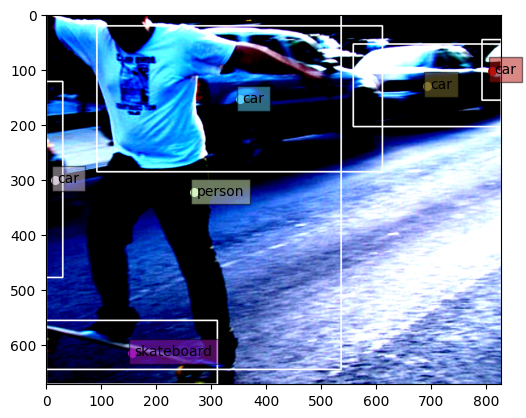

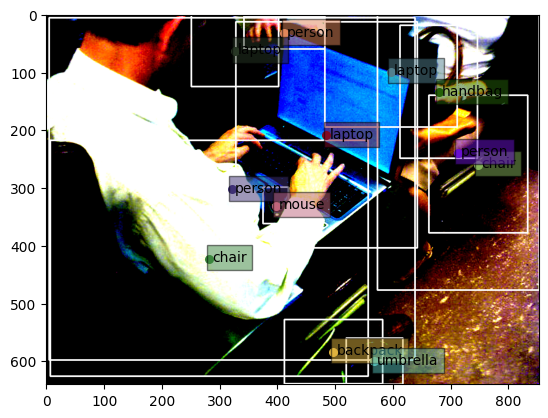

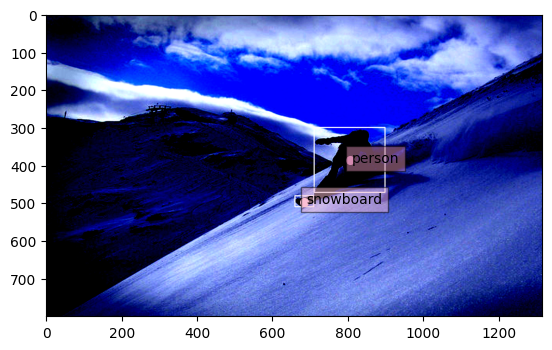

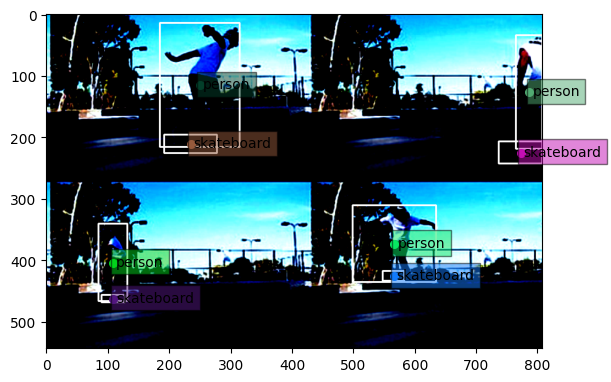

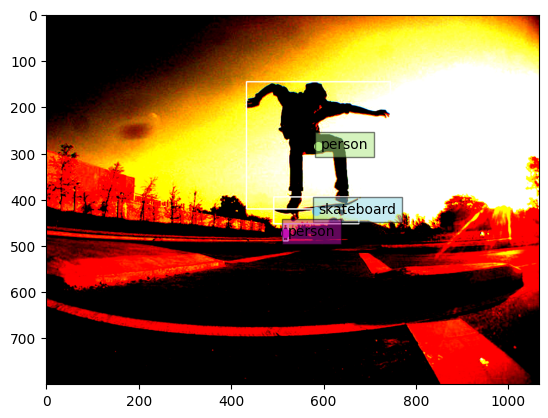

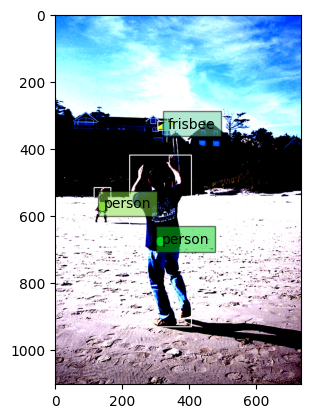

In [5]:
import cv2, random
from datasets.utils.vcoco_utils import valid_obj_ids, get_coco_instance_ID_to_name
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r

with torch.no_grad():
    for idx, batches in enumerate(train_data_loader):
        if idx > 2:
            break
        for key, batch in batches.items():
            for test in batch:
                target_img = test["image"]
                target = test["instances"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()
                hh, ww = img.shape[0], img.shape[1]
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                obj_labels = []
                labels = []
                verb_names = []
                ob_boxes = []
                sub_boxes = []

                obj_boxes = target['boxes']
                for test in range(obj_boxes.shape[0]):
                    cx, cy, w, h = obj_boxes[test]
                    color = random_color()
                    cx, cy, w, h = cx * ww, cy * hh, w * ww, h * hh
                    n_box = list(map(int, [cx - 0.5 * w, cy - 0.5 * h, cx + 0.5 * w, cy + 0.5 * h]))
                    x1, y1, x2, y2 = n_box
                    ob_boxes.append(n_box)
                    
                for idx in target['labels']:
                    label_name = get_coco_instance_ID_to_name(valid_obj_ids[idx])
                    labels.append(label_name)

                for label, box in zip(labels, ob_boxes):
                    color = random_color()
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    plt.text(
                        x + 5,
                        y + 5,
                        label,
                        fontsize=10,
                        bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                        )

                plt.imshow(img)
                plt.show()